In [2]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/19 14:36:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/19 14:36:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


[wrangle.py] reading case.csv


[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features


[wrangle.py] joining departments



df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only show

In [3]:
df.groupby("case_status").count().show()


+-----------+------+
|case_status| count|
+-----------+------+
|       Open| 18110|
|     Closed|823594|
+-----------+------+



Text(0.5, 0, 'Number of Cases')

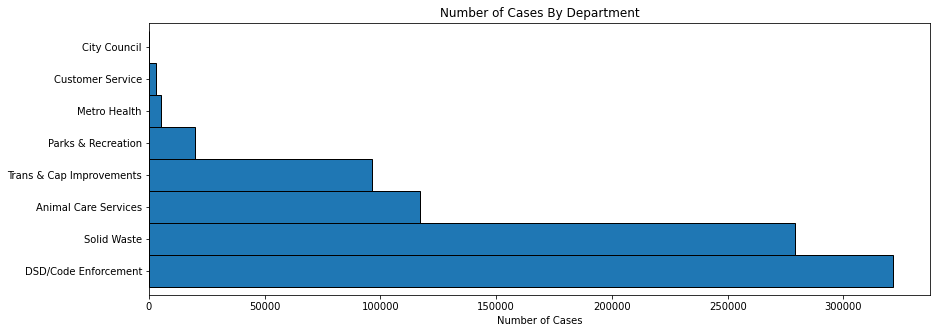

In [4]:
# First aggregate with spark
(
    df.groupBy("department")
    .count()
    # then pass to pandas
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")


In [5]:
(
    df.groupBy("department")
    .pivot("case_status")
    .agg(round(mean("case_lifetime"), 2))
    .orderBy("Closed")
    .show(truncate=False)
)


+------------------------+------+------+
|department              |Closed|Open  |
+------------------------+------+------+
|Solid Waste             |3.4   |16.45 |
|Animal Care Services    |5.51  |21.36 |
|Metro Health            |6.82  |4.64  |
|Trans & Cap Improvements|8.0   |54.39 |
|Parks & Recreation      |10.66 |64.72 |
|DSD/Code Enforcement    |15.64 |91.56 |
|City Council            |29.25 |154.07|
|Customer Service        |48.94 |172.94|
+------------------------+------+------+



In [6]:
sample = df.sample(fraction=0.01, seed=13).toPandas()
print("shape:", sample.shape)
sample.head()


shape: (8441, 20)


,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
0,1014127339,2018-01-01 06:58:00,2018-01-02 15:32:00,2018-01-17 08:30:00,False,-14.706620,True,Front Or Side Yard Parking,16.063796,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.100946,78251,219,1.0,1,DSD/Code Enforcement,True
1,1014127368,2018-01-01 07:18:00,2018-01-02 15:22:00,2018-01-17 08:30:00,False,-14.713275,True,Right Of Way/Sidewalk Obstruction,16.049769,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.101896,78251,219,1.0,1,DSD/Code Enforcement,True
2,1014127446,2018-01-01 11:27:00,2018-01-03 17:08:00,2018-01-06 11:27:00,False,-2.763333,True,Aggressive Animal(Non-Critical),5.000000,Closed,139344,SAN FERNANDO and SAN HORACIO S,005,-0.394762,,219,2.0,2,Animal Care Services,True
3,1014127470,2018-01-01 12:33:00,2018-01-01 12:43:00,2020-09-26 12:33:00,False,-998.993079,True,Stray Animal,999.000000,Closed,139344,"159 SURFRIDER, San Antonio, 78242",004,-142.713297,78242,219,0.0,0,Animal Care Services,True
4,1014127599,2018-01-01 15:25:00,2018-01-03 05:52:00,2018-01-02 03:25:00,True,1.101817,True,Trapped/Confined Animal,0.500000,Closed,rs16746,"633 ST MARYS S, San Antonio, 78205",001,0.157402,78205,219,2.0,2,Animal Care Services,True


In [7]:
pd.cut(sample.case_lifetime, 4).value_counts().sort_index()


(-0.579, 144.75]    8344
(144.75, 289.5]       71
(289.5, 434.25]       17
(434.25, 579.0]        9
Name: case_lifetime, dtype: int64